# Time-series to image transformation for photometric light curves
We aim to classify photometric transient events with an image classifier. To achieve this we first compute gramian angular field, and markov transition field transformations converting the time series data into an image. We do this for each wavelength band in the dataset (ugrizy). This results in a 12 channel image which we limit to 40 by 40 pixels through zero-padding and downsampling if needed.

See more here about the initial challenge here (https://www.kaggle.com/competitions/PLAsTiCC-2018)

### Gramian Angular Fields and Markov Transition Fields
#### See the original paper here (https://arxiv.org/abs/1506.00327)


To apply convolutional neural networks (CNNs) to time-series data, a common approach is to transform a 1D signal into a 2D image representation that preserves temporal dependencies and structure. Two effective transformations for this purpose are the **Gramian Angular Field (GAF)** and the **Markov Transition Field (MTF)**.

---

#### **1. Gramian Angular Field (GAF)**

The GAF encodes the global temporal correlation of a normalized time series by mapping each pair of time points into polar coordinates.

A normalized time series $(x_t \in [-1, 1])$ is first converted into angular values:

$
\theta_t = \arccos(x_t), \quad \theta_t \in [0, \pi]
$

Two common variants exist:

- **Gramian Angular Summation Field (GASF):**

  $
  G_{i,j}^{(S)} = \cos(\theta_i + \theta_j)
  $
- **Gramian Angular Difference Field (GADF):**

  $
  G_{i,j}^{(D)} = \sin(\theta_i - \theta_j)
  $

The resulting matrices are symmetric (GASF) or antisymmetric (GADF) and capture global correlation and temporal dynamics across the signal.

---

#### **2. Markov Transition Field (MTF)**

The MTF encodes the **probabilistic transitions** between discretized signal states over time.

After quantizing the series into $(Q)$ discrete bins, a Markov transition matrix $(P \in \mathbb{R}^{Q \times Q})$ is computed as:

$
P_{ij} = p(s_t = i \mid s_{t-1} = j)
$

These transition probabilities are then projected over time to form the field:

$
M_{m,n} = P_{q_m, q_n}
$

where $(q_m)$ and $(q_n)$ denote the quantized states at time steps $(m)$ and $(n)$.

---

Together, **GAFs** capture *global correlation structure* while **MTFs** capture *local transition dynamics*. Combining both provides a rich, complementary image representation of time-series behavior suitable for CNN-based classification.



In [98]:
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset

# Other
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

# some opinionated plot aesthetics
import matplotlib as mpl
mpl.rcParams["xtick.top"] = True
mpl.rcParams["ytick.right"] = True
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["ytick.minor.visible"] = True
mpl.rcParams["xtick.major.size"] = 5
mpl.rcParams["xtick.minor.size"] = 2.5
mpl.rcParams["ytick.major.size"] = 5
mpl.rcParams["ytick.minor.size"] = 2.5
mpl.rcParams["xtick.major.width"] = 1
mpl.rcParams["xtick.minor.width"] = 0.5
mpl.rcParams["ytick.major.width"] = 1
mpl.rcParams["ytick.minor.width"] = 0.5
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["font.family"] = "serif"


In [99]:
# add google drive access
drive.mount('/content/drive')   # follow the auth link

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training Hyperparameters Explained

Below are the key hyperparameters used to train the ResNet model.  
Each one controls a different aspect of how the network learns from data.

| Hyperparameter | Description |
|----------------|--------------|
| **`BATCH_SIZE = 128`** | The number of samples processed before updating the model weights once. Larger batches make training smoother (better gradient estimates), but need more memory. Powers of 2 (like 64, 128, 256) are common for computational efficiency on GPUs. |
| **`LEARNING_RATE = 0.05`** | Controls how big each update step is when the optimizer adjusts the weights. A high learning rate can make training unstable (loss jumps around), while a low one can make learning too slow or get stuck. This is *the most important* hyperparameter to tune. |
| **`NUM_EPOCHS = 30`** | The number of complete passes over the entire training dataset. Each epoch means the model has seen all training examples once. More epochs usually improve accuracy up to a point, after which the model may start to overfit. |
| **`WEIGHT_DECAY = 2e-4`** | A form of *L2 regularization* that penalizes large weights by adding a small term to the loss function. This helps prevent overfitting by encouraging smaller, smoother parameter values. Higher values increase regularization strength. |
| **`DROPOUT_P = 0.3`** | The probability of "dropping" (zeroing out) a neuron’s output during training. This prevents co-adaptation and overfitting by forcing the network to learn redundant representations. A value of 0.3 means 30% of neurons are dropped at random in each update step. |
| **`USE_ADAM = True`** | Chooses which optimizer to use. If `True`, uses **Adam**, an adaptive optimizer that adjusts learning rates for each parameter (faster convergence, less tuning). If `False`, uses **SGD (Stochastic Gradient Descent)**, which is simpler but often performs better for large datasets when tuned carefully. |

---

**Notes:**
- The learning rate (`LEARNING_RATE`) is the most important hyperparameter and controls how far you step in weight space for each update.
- Weight decay (`WEIGHT_DECAY`) is a regularization techniqye usually tuned together with the learning rate. I would likely range this between $[0 \to 0.01]$. Larger number for stronger L2 regularization.  
- Batch size affects both *training speed* and *model generalization*, but can also be memory (RAM) limited.  
- Dropout is often unnecessary in ResNets because BatchNorm already provides regularization at each layer — but it’s a good experiment variable to test.  For the CNN models this is very useful and you can think of it as kind of turning you one large CNN, into a subgroup of mini CNNs. I.e we train it as a psuedo-ensemble method.
- Always start by checking if the model can **overfit a small dataset**. If it can’t, the issue isn’t regularization — it’s learning rate, architecture, or data setup.


In [100]:
# Training hyperparameters (at the start is a personal preference choice)
BATCH_SIZE = 128      # batch size for mini-batch (SGD), you'll often see powers of 2 here from classical comp reasons
LEARNING_RATE = 0.001 # learning rate of the gradient updates, play around with this a lot
NUM_EPOCHS = 30       # how many training epochs
WEIGHT_DECAY = 1e-4   # the weight decay (L2 regularization)
DROPOUT_P = 0.0       # the dropout rate to regularize the net
USE_ADAM = True       # we can use the Adam optimiser or SGD

In [101]:
# I like to try to have all my function/class definitions at the start if possible, just again a personal preference
def get_accuracy(logits, labels):
    """Return fraction correct in [0,1]"""
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)              # actual batch size (handles last small batch)
    return correct / total

class NPZDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class NumpyCHWToTensor:
    def __call__(self, x):
        import torch, numpy as np
        if isinstance(x, np.ndarray):
            t = torch.from_numpy(x)
        else:
            t = x
        assert t.ndim == 3, f"expect [C,H,W], got {t.shape}"
        # if someone passed HWC by mistake, fix it:
        if t.shape[0] not in (1,3,12) and t.shape[-1] in (1,3,12):
            t = t.permute(2,0,1)  # HWC -> CHW
        return t.float()

def compute_mean_std_per_channel(dataset, batch_size=64, num_workers=2):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    C = None
    n_pixels = 0
    mean = None
    M2 = None  # running variance helper

    for imgs, _ in loader:                 # imgs: [B,C,H,W]
        assert imgs.ndim == 4, f"Expected [B,C,H,W], got {tuple(imgs.shape)}"
        B, c, H, W = imgs.shape
        if C is None:
            C = c
            mean = imgs.new_zeros(C)
            M2   = imgs.new_zeros(C)

        x = imgs.view(B, C, -1)            # [B,C,N]
        batch_mean = x.mean(dim=(0,2))     # [C]
        batch_var  = x.var (dim=(0,2), unbiased=False)  # [C]
        m = B * H * W

        if n_pixels == 0:
            mean = batch_mean
            M2   = batch_var * m
            n_pixels = m
        else:
            delta = batch_mean - mean
            total = n_pixels + m
            mean = mean + delta * (m / total)
            M2   = M2 + batch_var * m + (delta**2) * (n_pixels*m/total)
            n_pixels = total

    std = (M2 / max(n_pixels, 1)).sqrt()
    return mean.cpu(), std.cpu()

# create label for object class used later
label_dict = {90: 'SNIa',
              67: 'SNIa-91bg',
              52: 'SNIax',
              42: 'SNII',
              62: 'SNIbc',
              95: 'SLSN-I',
              15: 'TDE',
              64: 'KN',
              88: 'AGN',
              92: 'RRL',
              65: 'M-dwarf',
              16: 'EB',
              53: 'Mira',
              6: r'$\mu$-Lens',
              }

In [102]:
# let us load in the raw data
data = np.load('/content/drive/MyDrive/training-data/gaf-mtf-training_images_labels.npz', allow_pickle=True)
X = data['X']
X = X.astype('float32')
y = data['y']
class_names = data['class_names']
print(f"shape of images {X.shape}")
print(f"shape of class labels {y.shape}")

shape of images (7848, 40, 40, 12)
shape of class labels (7848,)


In [103]:
# Convert labels to numpy if needed
y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

# Use label_dict keys (sorted for reproducibility) as the source of truth
unique_labels = sorted(label_dict.keys())  # preserves stable numeric order
label2idx = {lab: i for i, lab in enumerate(unique_labels)}
idx2label = {i: lab for lab, i in label2idx.items()}
num_classes = len(unique_labels)

# Remap y using the fixed mapping
y_mapped_np = np.vectorize(label2idx.get)(y_np)
y = torch.tensor(y_mapped_np, dtype=torch.long)

# Class names aligned to new indices
class_names = [label_dict[idx2label[i]] for i in range(num_classes)]

In [104]:
# now transform the raw data into a dataset format and calculate mean and std for normalization
raw_train = NPZDataset(X, y, transform=NumpyCHWToTensor())
mean, std = compute_mean_std_per_channel(raw_train)

# now make a fresh dataset, with a train/test split and normalize and perform some augmentations
dataset = NPZDataset(X, y)

# split into train/val/test
n = len(dataset)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)
n_test  = n - n_train - n_val
g = torch.Generator().manual_seed(42)   # reproducibility
trainset, valset, testset = random_split(dataset, [n_train, n_val, n_test], generator=g)

# define transforms
train_transform = transforms.Compose([
    NumpyCHWToTensor(),
    transforms.RandomResizedCrop(40, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

eval_transform = transforms.Compose([
    NumpyCHWToTensor(),
    transforms.CenterCrop(40),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# assign transforms dynamically
trainset.dataset.transform = train_transform
valset.dataset.transform = eval_transform
testset.dataset.transform = eval_transform

# finally we create our training and test iterators
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader  = DataLoader(valset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [105]:
# check things are in the dimensions we expect
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([128, 12, 40, 40])
Image label dimensions: torch.Size([128])


## Exploring the Data
It is always good to make sure things look right

Image shape: torch.Size([12, 40, 40])
Label: 8


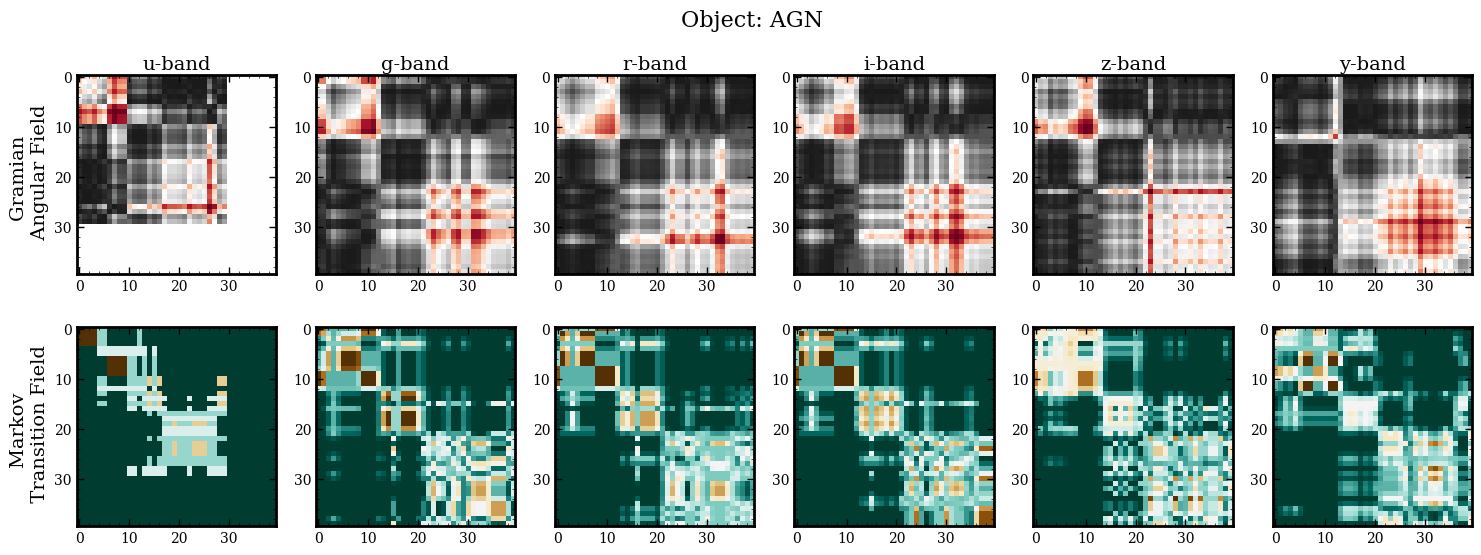

In [106]:
# pick an index
idx = 1234
image, label = trainset[idx]
print("Image shape:", image.shape)
print("Label:", y[idx].item())

# ensure tensor is detached and on CPU
image = image.cpu() if image.is_cuda else image

# define labels
band_labels = ["u-band", "g-band", "r-band", "i-band", "z-band", "y-band"]

# create 2x6 grid
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.reshape(2, 6)

for row in range(2):
    for col in range(6):
        ch = row * 6 + col
        ax = axes[row, col]
        # add column labels (bands)
        if row == 0:
          ax.set_title(band_labels[col], fontsize=14, pad=4)
          ax.imshow(image[ch].numpy(), cmap='RdGy_r')
          if col == 0:
            ax.set_ylabel("Gramian \n Angular Field", fontsize=14)
        else:
          ax.imshow(image[ch].numpy(), cmap='BrBG_r')
          if col == 0:
            ax.set_ylabel("Markov \n Transition Field", fontsize=14)



# main title
fig.suptitle(f'Object: {class_names[label]}', fontsize=16)
plt.show()


### CNN Model Description

We use a compact convolutional neural network tailored to 12-channel inputs. The backbone comprises three 3×3 convolutional stages with Batch Normalization and ReLU activations; each stage is followed by 2×2 max-pooling to progressively reduce spatial resolution. Spatial Dropout (`Dropout2d`) after the first two pooling layers regularizes early feature maps. The final convolutional output (128 channels) is flattened and passed through a 256-unit fully connected layer with dropout before a final linear classifier that outputs logits for `num_classes`. The model is trained with cross-entropy loss and Adam, using per-channel normalization and lightweight data augmentation (random resized crop, horizontal flip, and small rotations). This design balances capacity and regularization for small 40×40 inputs while preserving interpretability of the feature hierarchy.



In [107]:
# a medium size CNN
class CNN_medium(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2,2)
        self.drop2d = nn.Dropout2d(p=0.15)
        self.fc1 = nn.Linear(128*5*5, 256)
        self.drop = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

# a smaller CNN to reduce overfitting
class CNN_small(nn.Module):
    def __init__(self, num_classes=10, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(12, 24, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 48, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(96)

        self.pool  = nn.MaxPool2d(2,2)
        self.drop2d = nn.Dropout2d(p=0.15)

        # Replace big flatten+FC with GAP -> small FC
        self.gap   = nn.AdaptiveAvgPool2d(1)
        self.head  = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(96, num_classes)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2d(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)            # B x 96 x 1 x 1
        return self.head(x)

# we can also build a ResNet (https://arxiv.org/abs/1512.03385)
# these models are often more powerful (higher capacity) but
# can be hard to train in the low data limit
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self, block=BasicBlock, layers=(2,2,2,2), num_classes=10, in_channels=3, dropout=0.0):
        super().__init__()
        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout) if dropout and dropout > 0 else nn.Identity()
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x) # add a dropout layer to help regularize
        x = self.fc(x)
        return x

# ResNet18 constructor
ResNet18 = ResNet(BasicBlock, layers=(2,2,2,2), num_classes=num_classes, in_channels=12, dropout=DROPOUT_P)

# choose the ResNet, CNN_medium or CNN_small model
MyModel = ResNet18

This is useful for CUDA/GPU debugging, sometimes errors are just due to not pushing things to correct devices.

In [108]:
# labels remapped earlier -> y_mapped
num_classes = int(len(np.unique(y)))

# model on CPU sanity check
if MyModel == ResNet18:
  model = MyModel
  print("Using ResNet18")
  pass
else:
  model = MyModel(num_classes=num_classes).cpu()
  print("Using CNN")
images, labels = next(iter(trainloader))
print('shapes:', images.shape, labels.shape)
print('label range:', labels.min().item(), labels.max().item())

with torch.no_grad():
    logits = model(images.float())
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(logits, labels.long())
print('CPU forward/loss OK')

# now go to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
images = images.to(device).float()
labels = labels.to(device).long()
logits = model(images)
loss = criterion(logits, labels)
loss.backward()
print('GPU step OK')

Using ResNet18
shapes: torch.Size([128, 12, 40, 40]) torch.Size([128])
label range: 0 13
CPU forward/loss OK
GPU step OK


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model.

In [109]:
# instantiate the model class, optimizer, and create a learning rate schedule
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if MyModel == ResNet18:
  pass
else:
  model = MyModel(num_classes=num_classes, dropout=DROPOUT_P)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

# see other optimizers that may interest you here (https://docs.pytorch.org/docs/main/optim.html#torch.optim.Optimizer)
if USE_ADAM:
  # an adam optimizer
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=LEARNING_RATE,
                              weight_decay=WEIGHT_DECAY)
else:
  # use a (mostly) vanilla stochastic gradient descent optimizer
  optimizer = torch.optim.SGD(model.parameters(),
      lr=LEARNING_RATE,
      momentum=0.9,     # typical value: 0.9
      nesterov=True,    # enables Nesterov acceleration
      weight_decay=WEIGHT_DECAY
  )

# use a cosine-onecycle learning rate schedule (https://docs.pytorch.org/docs/main/generated/torch.optim.lr_scheduler.OneCycleLR.html)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(trainloader), epochs=NUM_EPOCHS
)

Now let us train our model

In [110]:
# print the training metrics every print_every epoch
print_every = 1

# jump in
for epoch in range(NUM_EPOCHS):
    # training
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for images, labels in trainloader:
        images = images.to(device).float()
        labels = labels.to(device).long()

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # if using OneCycleLR

        # accumulate sample-accurate stats
        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = running_correct / total_samples

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device).float()
            labels = labels.to(device).long()

            logits = model(images)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

    val_loss /= len(valloader)
    val_acc = val_correct / val_samples

    # print summary
    if (epoch+1) % print_every == 0:
      print(
         f"▸ epoch ({epoch+1}/{NUM_EPOCHS}) "
         f"| train loss: {epoch_loss:.4f} | train acc: {epoch_acc*100:.2f}% "
         f"| val loss: {val_loss:.4f} | val acc: {val_acc*100:.2f}%"
      )


▸ epoch (1/30) | train loss: 0.9609 | train acc: 64.97% | val loss: 1.2420 | val acc: 58.28%
▸ epoch (2/30) | train loss: 0.9351 | train acc: 66.50% | val loss: 1.2434 | val acc: 58.96%
▸ epoch (3/30) | train loss: 0.9583 | train acc: 65.17% | val loss: 1.2450 | val acc: 59.13%
▸ epoch (4/30) | train loss: 0.9578 | train acc: 65.37% | val loss: 1.2419 | val acc: 58.28%
▸ epoch (5/30) | train loss: 0.9497 | train acc: 65.41% | val loss: 1.2489 | val acc: 58.54%
▸ epoch (6/30) | train loss: 0.9466 | train acc: 66.14% | val loss: 1.2468 | val acc: 58.03%
▸ epoch (7/30) | train loss: 0.9483 | train acc: 65.56% | val loss: 1.2509 | val acc: 57.18%
▸ epoch (8/30) | train loss: 0.9185 | train acc: 66.81% | val loss: 1.2672 | val acc: 58.03%
▸ epoch (9/30) | train loss: 0.9158 | train acc: 66.41% | val loss: 1.2650 | val acc: 58.54%
▸ epoch (10/30) | train loss: 0.9063 | train acc: 67.12% | val loss: 1.2540 | val acc: 58.54%
▸ epoch (11/30) | train loss: 0.8991 | train acc: 67.19% | val loss: 

Now, training and validation performance is one thing, but we really care about test performance, so let us run our model (in evalutate mode to remove dropout) and see how accurate we are on the unseen test set.

Though often, if we are not doing early stopping or large hyper-parameter sweeps the validation accuracy should be a close approximation to the test accuracy.

In [111]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device).float()
        labels = labels.to(device).long()
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total if test_total else 0.0
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 55.77%


## Analysis tools
A useful visual tool to inspect what is going on with multi-class classification algorithms is the classic confusion matrix. This lets us see what classes we are correctly prediction, which we are not, and what classes we are assigning when we get our prediction wrong.

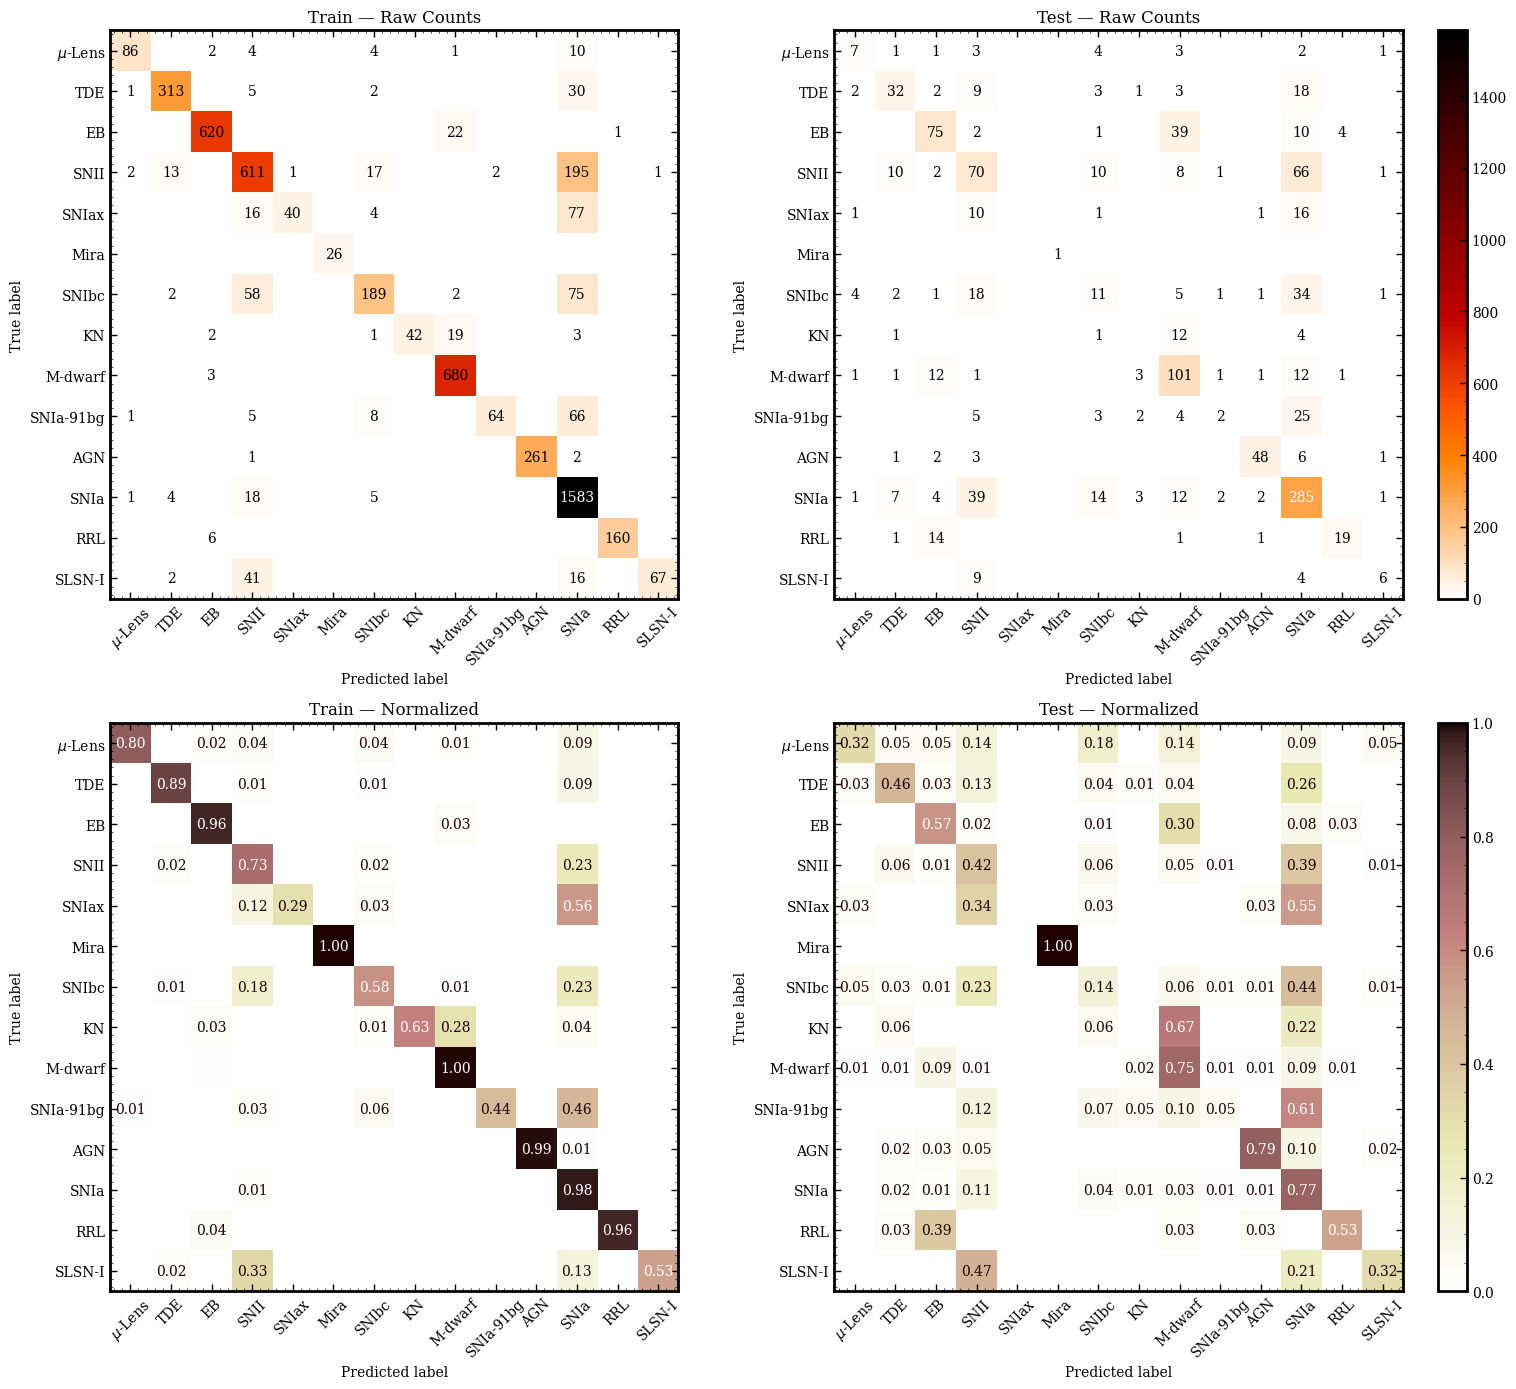

In [112]:

# the test predictions
all_true, all_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_test = np.concatenate(all_true)
y_pred_test = np.concatenate(all_pred)

# the train predictions
all_true, all_pred = [], []
with torch.no_grad():
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_true.append(labels.cpu().numpy())
        all_pred.append(preds.cpu().numpy())

y_true_train = np.concatenate(all_true)
y_pred_train = np.concatenate(all_pred)

# create confusion matrices
labels_order = list(range(num_classes))
cm_test  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=labels_order)
cm_test_norm  = confusion_matrix(y_true_test,  y_pred_test,  labels=labels_order, normalize="true")
cm_train_norm = confusion_matrix(y_true_train, y_pred_train, labels=labels_order, normalize="true")

# Shared color scale for raw counts
vmax = max(cm_test.max(), cm_train.max())
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# remove zero texts (similar style to https://arxiv.org/abs/2012.12392)
def hide_zero_texts(disp, cm):
    """Remove text labels where the confusion matrix value is zero."""
    for (i, j), value in np.ndenumerate(cm):
        if value < 0.005 and disp.text_[i, j] is not None:
            disp.text_[i, j].set_text("")

# Row 1: raw counts
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0, 0], cmap="gist_heat_r", colorbar=False, values_format="d")
axes[0, 0].images[0].set_clim(0, vmax)
axes[0, 0].set_title("Train — Raw Counts")
axes[0, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train, cm_train)

disp_test = ConfusionMatrixDisplay(cm_test, display_labels=class_names)
disp_test.plot(ax=axes[0, 1], cmap="gist_heat_r", colorbar=True, values_format="d")
axes[0, 1].images[0].set_clim(0, vmax)
axes[0, 1].set_title("Test — Raw Counts")
axes[0, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test, cm_test)

# Row 2: normalized
disp_train_norm = ConfusionMatrixDisplay(cm_train_norm, display_labels=class_names)
disp_train_norm.plot(ax=axes[1, 0], cmap="pink_r", colorbar=False, values_format=".2f")
axes[1, 0].set_title("Train — Normalized")
axes[1, 0].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_train_norm, cm_train_norm)

disp_test_norm = ConfusionMatrixDisplay(cm_test_norm, display_labels=class_names)
disp_test_norm.plot(ax=axes[1, 1], cmap="pink_r", colorbar=True, values_format=".2f")
axes[1, 1].set_title("Test — Normalized")
axes[1, 1].tick_params(axis="x", labelrotation=45)
hide_zero_texts(disp_test_norm, cm_test_norm)

plt.tight_layout()
plt.show()
